# Creating 2D mask from shapefile
In this notebook, we will create a 2D mask using a shapefile containing the boundaries of the regions of interest. You will also need a sample of the target grid to create the mask.

## Loading libraries

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gp
import pandas as pd
import regionmask
import numpy as np
%matplotlib inline

C:\Users\Denisse\AppData\Local\Temp\ipykernel_5808\2486387503.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gp


## Loading shapefile with regions of interest

<AxesSubplot:>

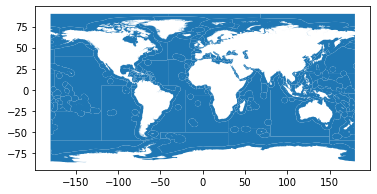

In [3]:
#Loading file
regions = gp.read_file(r'../Spatial_Data/Merged_FAO_EEZ/FAO-MajorAreas_EEZs.shp')
#Checking contents
regions.plot()

In [4]:
#We can also check the name of the columns
regions.columns

Index(['F_CODE', 'F_LEVEL', 'OCEAN', 'SUBOCEAN', 'NAME_EN', 'NAME_FR',
       'NAME_ES', 'MRGID', 'GEONAME', 'POL_TYPE', 'SOVEREIGN1', 'SOVEREIGN2',
       'SOVEREIGN3', 'ID_merged', 'name_merge', 'geometry'],
      dtype='object')

## Loading `netcdf` file 
This file contains the target grid for the 2D mask that we are about to create.

In [108]:
#We now this file contains the area for each pixel, so we simply load the area
mask = xr.open_dataset(r'../Spatial_Data/Masks/area_05deg.nc').area
#Checking contents
mask

<xarray.DataArray 'area' (lat: 360, lon: 720)>
[259200 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
Attributes:
    units:         km2
    grid_mapping:  crs
    proj4:         +proj=longlat +datum=WGS84 +no_defs
    min:           13.472201821059585
    max:           3077.2397067484308

## Plotting shapefile and target grid
This step is necessary to ensure that both variables are in the same reference system and that the longitude has the same limits (e.g., +/- $180^{\circ}$ or $0^{\circ}$-$360^{\circ}$).

<AxesSubplot:xlabel='lon [degrees_east]', ylabel='lat [degrees_north]'>

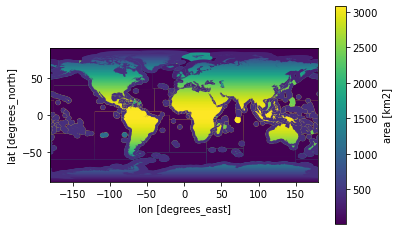

In [109]:
fig = plt.figure()
ax = fig.add_subplot()
mask.plot(ax = ax)
regions.plot(ax = ax, column = 'ID_merged')

## Creating mask from shapefile
There are several steps involved in the mask creation. These steps are broken down below.

### Getting latitude and longitude values from target grid

In [110]:
lat = mask.lat.values
lon = mask.lon.values

### Creating mask using shapefile and coordinates above

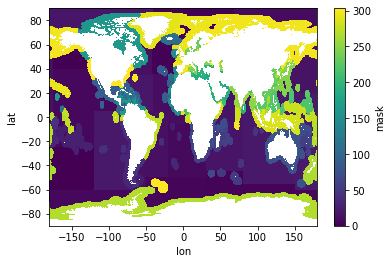

In [111]:
mask_2D = regionmask.mask_geopandas(regions, lon, lat)
#We can plot the result to ensure our mask makes sense
mask_2D.plot()

### Changing IDs from row index to ID field in the shapefile
The above mask has values that identify each region and are based on the row index of the shapefile. We will correct this and ensure that any regions that have multiple polygons (i.e., along international date line) have a single ID.  
  
The first step is to extract the regions that are actually showing in the mask. This is an important step, particularly with low resolution masks, as one region may be smaller than a single grid pixel and may not be shown in the mask.

In [112]:
#We extract unique values, otherwise we would get the entire array
region_vals = np.unique(mask_2D.values)
#We remove any NA values
region_vals = region_vals[~np.isnan(region_vals)]

We will create a data array with the same dimension as our target grid, but we will fill it with `NA` values.

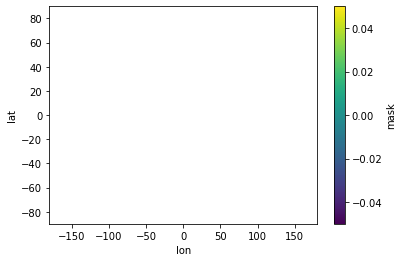

In [113]:
corrected_mask2D = xr.full_like(mask_2D, np.nan)
#We can check what this looks like
corrected_mask2D.plot()

We will loop through each unique index value identified above and change the index for the unique ID contained in the shapefile.

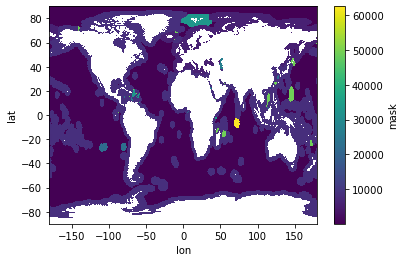

In [114]:
for i in region_vals:
    corrected_mask2D = xr.where(mask_2D == i, regions.ID_merged[i], corrected_mask2D)

# We can check the result
corrected_mask2D.plot()

We can double check that the number of unique values in our corrected mask match the number of unique regions include in the mask.

In [115]:
print(len(np.unique(regions.iloc[region_vals].name_merge)),
len(np.unique(corrected_mask2D.values)))

270 271


The first value refers to the unique region names found in the original mask, and the second value refers to the unique values found in the newly created mask.

## Adding mask as an additional coordinate for easy data grouping
We can use the corrected mask as an extra coordinate in the `area per pixel` file so we can use this information to group our dataset.

In [116]:
#We associate the mask to latitude and longitude to avoid adding an extra dimension
mask.coords['mask_FAO_EEZ'] = (('lat', 'lon'), corrected_mask2D.values)
#Checking result
mask

<xarray.DataArray 'area' (lat: 360, lon: 720)>
[259200 values with dtype=float32]
Coordinates:
  * lon           (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat           (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
    mask_FAO_EEZ  (lat, lon) float64 18.0 18.0 18.0 18.0 ... nan nan nan nan
Attributes:
    units:         km2
    grid_mapping:  crs
    proj4:         +proj=longlat +datum=WGS84 +no_defs
    min:           13.472201821059585
    max:           3077.2397067484308

## Saving resulting mask to disk

In [117]:
mask.to_netcdf(r'../Spatial_Data/Masks/area_05deg_mask_FAO-EEZ.nc')